In [1]:
#TASK1-MULTINOMIAL NAIVE BAYES(SENTIMENTAL ANALYSIS DATASET)
!pip install -q scikit-learn --upgrade
import zipfile, io, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 52.0 MB/s eta 0:00:00


In [2]:
from google.colab import files
uploaded = files.upload()

Saving swiggydataset.csv.zip to swiggydataset.csv.zip


In [3]:
import glob
uploaded_names = list(uploaded.keys())
print("Uploaded:", uploaded_names)
csv_path = None
for name in uploaded_names:
    if name.lower().endswith('.zip'):
        z = zipfile.ZipFile(io.BytesIO(uploaded[name]))
        z.extractall()
        csvs = glob.glob("**/*.csv", recursive=True)
        if csvs:
            csv_path = csvs[0]
            break
    elif name.lower().endswith('.csv'):
        csv_path = name
        break
if csv_path is None:
    raise FileNotFoundError("No CSV found in uploaded files. Please upload a .csv or .zip containing a .csv")
print("Using CSV:", csv_path)
df = pd.read_csv(csv_path, encoding='utf-8', engine='python')
print("Rows,Cols:", df.shape)
df.head()

Uploaded: ['swiggydataset.csv.zip']
Using CSV: swiggydataset.csv
Rows,Cols: (16712, 10)


,date,favorite_count,followers_count,friends_count,full_text,retweet_count,retweeted,screen_name,tweet_id,user_id
0,7/18/2019 22:47,0,82,219,@Mahi_2510 @swiggy_in The ultimate answer will...,0,False,syamantak1,1,"6,19,59,419"
1,7/18/2019 22:43,0,102,129,@SwiggyCares I hope so.,0,False,Bharatbbhushn,2,"14,32,84,383"
2,7/18/2019 22:37,0,102,129,@SwiggyCares I think you have the order detail...,0,False,Bharatbbhushn,3,"14,32,84,383"
3,7/18/2019 22:35,0,13,16,"@swiggy_in People are complaining here also, i...",0,False,taifkhalid01,4,"8,30,34,00,00,00,00,00,000"
4,7/18/2019 22:25,0,102,129,@SwiggyCares Do you even know the meaning of y...,0,False,Bharatbbhushn,5,"14,32,84,383"


In [9]:
# Heuristics to find text and label columns
text_candidates = ['review','text','message','feedback','comment','content','body','full_text']
label_candidates = ['sentiment','label','target','class','rating','tag','retweeted']

cols = df.columns.str.lower().tolist()
text_col = None
label_col = None

for c in text_candidates:
    for orig in df.columns:
        if c == orig.lower():
            text_col = orig
            break
    if text_col:
        break

for c in label_candidates:
    for orig in df.columns:
        if c == orig.lower():
            label_col = orig
            break
    if label_col:
        break

print("Auto-detected text column:", text_col)
print("Auto-detected label column:", label_col)

# Keep only relevant columns
df_small = df[[text_col, label_col]].dropna().copy()
df_small.columns = ['text', 'label']

# Label is numeric for your dataset (retweeted = 0/1)
df_small['label'] = df_small['label'].astype(int)

# Use first 200 rows
n_samples = min(200, len(df_small))
df_sample = df_small.iloc[:n_samples].reset_index(drop=True)

print("Using sample rows:", len(df_sample))
df_sample.label.value_counts()


Auto-detected text column: full_text
Auto-detected label column: retweeted
Using sample rows: 200


,count
label,
0,200


In [12]:
from sklearn.model_selection import train_test_split
import numpy as np
if len(df_sample) >= 200:
    train_df = df_sample.iloc[:150].copy()
    test_df  = df_sample.iloc[150:200].copy()
else:
    train_df, test_df = train_test_split(df_sample, test_size=0.25, random_state=42, stratify=df_sample['label'])
X_train_text = train_df['text'].astype(str).values
X_test_text  = test_df['text'].astype(str).values
y_train = train_df['label'].astype(int).values
y_test  = test_df['label'].astype(int).values
print("Train size:", len(X_train_text), "Test size:", len(X_test_text))
print("Label distribution (train):\n", np.bincount(y_train))
print("Label distribution (test):\n", np.bincount(y_test))

Train size: 150 Test size: 50
Label distribution (train):
 [150]
Label distribution (test):
 [50]


In [13]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(stop_words='english', max_features=5000)
X_train_counts = vectorizer.fit_transform(X_train_text)
X_test_counts  = vectorizer.transform(X_test_text)
print("Count vector shape (train):", X_train_counts.shape)
print("Count vector shape (test):", X_test_counts.shape)

Count vector shape (train): (150, 934)
Count vector shape (test): (50, 934)


In [14]:
from sklearn.naive_bayes import MultinomialNB
mnb_counts = MultinomialNB(alpha=1.0)
mnb_counts.fit(X_train_counts, y_train)
print("Trained MultinomialNB on count features.")

Trained MultinomialNB on count features.


In [15]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
y_pred_counts = mnb_counts.predict(X_test_counts)
acc_counts = accuracy_score(y_test, y_pred_counts)
print("Accuracy (MultinomialNB on counts):", acc_counts)
print("\nClassification report:\n", classification_report(y_test, y_pred_counts))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_counts))

Accuracy (MultinomialNB on counts): 1.0

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        50

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50

Confusion matrix:
 [[50]]


In [17]:
from sklearn.decomposition import TruncatedSVD
import numpy as np
X_all_counts = np.vstack([X_train_counts.toarray(), X_test_counts.toarray()]) if X_train_counts.shape[1] <= 2000 else None
if X_all_counts is None:
    from scipy.sparse import vstack
    X_all_sparse = vstack([X_train_counts, X_test_counts])
    svd = TruncatedSVD(n_components=2, random_state=42)
    X_all_2d = svd.fit_transform(X_all_sparse)
else:
    svd = TruncatedSVD(n_components=2, random_state=42)
    X_all_2d = svd.fit_transform(X_all_counts)
n_train = len(X_train_text)
X_train_2d = X_all_2d[:n_train]
X_test_2d  = X_all_2d[n_train:]
print("2D projection shape:", X_all_2d.shape)

2D projection shape: (200, 2)


In [18]:
min_val = X_all_2d.min()
if min_val <= 0:
    X_all_2d_shifted = X_all_2d - min_val + 1e-6
else:
    X_all_2d_shifted = X_all_2d.copy()
X_train_2d_shifted = X_all_2d_shifted[:n_train]
X_test_2d_shifted  = X_all_2d_shifted[n_train:]
mnb_2d = MultinomialNB(alpha=1.0)
mnb_2d.fit(X_train_2d_shifted, y_train)
print("Trained MultinomialNB on shifted 2D features (for visualization).")

Trained MultinomialNB on shifted 2D features (for visualization).


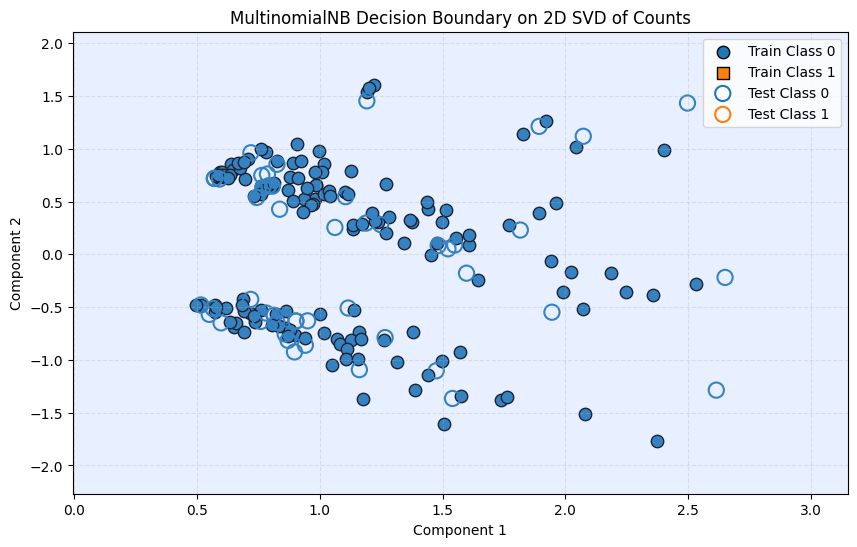

In [19]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10,6))
plt.scatter(X_train_2d[y_train==0,0], X_train_2d[y_train==0,1], marker='o', s=80, label='Train Class 0', edgecolor='k')
plt.scatter(X_train_2d[y_train==1,0], X_train_2d[y_train==1,1], marker='s', s=80, label='Train Class 1', edgecolor='k')
plt.scatter(X_test_2d[y_test==0,0], X_test_2d[y_test==0,1], facecolors='none', edgecolors='C0', s=120, linewidths=1.5, label='Test Class 0')
plt.scatter(X_test_2d[y_test==1,0], X_test_2d[y_test==1,1], facecolors='none', edgecolors='C1', s=120, linewidths=1.5, label='Test Class 1')
x_min, x_max = X_all_2d[:,0].min() - 0.5, X_all_2d[:,0].max() + 0.5
y_min, y_max = X_all_2d[:,1].min() - 0.5, X_all_2d[:,1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
grid = np.c_[xx.ravel(), yy.ravel()]
if min_val <= 0:
    grid_shifted = grid - min_val + 1e-6
else:
    grid_shifted = grid.copy()
Z = mnb_2d.predict(grid_shifted).reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.2, cmap=plt.cm.coolwarm)
plt.title("MultinomialNB Decision Boundary on 2D SVD of Counts")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(loc='upper right')
plt.grid(alpha=0.3, linestyle='--')
plt.show()

In [21]:
#TASK2-BERNOULLI NAIVES BAYES(FAKE NEWS DETECTION DATASET)
!pip install -q scikit-learn
import os, io, zipfile, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
import joblib
import warnings
warnings.filterwarnings("ignore")
print("Imports ready.")

Imports ready.


In [22]:
possible_paths = [
    "/mnt/data/fake_news_dataset.csv",
    "fake_news_dataset.csv",
    "/content/fake_news_dataset.csv"
]
csv_path = None
for p in possible_paths:
    if os.path.exists(p):
        csv_path = p
        break
if csv_path is None:
    from google.colab import files
    print("No dataset found in default paths. Please upload your CSV (e.g., fake_news_dataset.csv).")
    uploaded = files.upload()
    for name in uploaded.keys():
        if name.lower().endswith('.csv'):
            csv_path = name
            break
if csv_path is None:
    raise FileNotFoundError("No CSV provided. Upload a .csv file or place it at /mnt/data/fake_news_dataset.csv")
else:
    print("Using CSV:", csv_path)

No dataset found in default paths. Please upload your CSV (e.g., fake_news_dataset.csv).


Saving fake_news_dataset.csv to fake_news_dataset.csv
Using CSV: fake_news_dataset.csv


In [23]:
df = pd.read_csv(csv_path, encoding='utf-8', engine='python')
print("Dataset shape:", df.shape)
print("Columns:\n", df.columns.tolist())
display(df.head(3))

Dataset shape: (20000, 7)
Columns:
 ['title', 'text', 'date', 'source', 'author', 'category', 'label']


,title,text,date,source,author,category,label
0,Foreign Democrat final.,more tax development both store agreement lawy...,2023-03-10,NY Times,Paula George,Politics,real
1,To offer down resource great point.,probably guess western behind likely next inve...,2022-05-25,Fox News,Joseph Hill,Politics,fake
2,Himself church myself carry.,them identify forward present success risk sev...,2022-09-01,CNN,Julia Robinson,Business,fake


In [25]:
text_candidates = ['text','review','full_text','content','message','body','article','headline']
label_candidates = ['label','target','class','sentiment','is_fake','fake','truth','retweeted']
text_col = None
label_col = None
cols_lower = {col: col.lower() for col in df.columns}
for cand in text_candidates:
    for orig, low in cols_lower.items():
        if cand == low:
            text_col = orig
            break
    if text_col:
        break
for cand in label_candidates:
    for orig, low in cols_lower.items():
        if cand == low:
            label_col = orig
            break
    if label_col:
        break
if text_col is None:
    avg_lens = {}
    for col in df.columns:
        try:
            avg_lens[col] = df[col].dropna().astype(str).map(len).mean()
        except:
            avg_lens[col] = 0
    text_col = max(avg_lens, key=avg_lens.get)
if label_col is None:
    uniq_counts = {col: df[col].nunique(dropna=True) for col in df.columns if col != text_col}
    label_col = min(uniq_counts, key=uniq_counts.get)
print("Auto-detected text column:", text_col)
print("Auto-detected label column:", label_col)
df_small = df[[text_col, label_col]].dropna().copy()
df_small.columns = ['text', 'label']
if pd.api.types.is_numeric_dtype(df_small['label']):
    df_small['label'] = df_small['label'].astype(int)
else:
    df_small['label'] = df_small['label'].astype(str).str.lower().map(lambda x: 1 if ('fake' in x or '1'==x.strip() or 'true' in x) else 0)
n_samples = min(200, len(df_small))
df_sample = df_small.iloc[:n_samples].reset_index(drop=True)
print("Using sample rows:", len(df_sample))
print(df_sample.label.value_counts())

Auto-detected text column: text
Auto-detected label column: label
Using sample rows: 200
label
1    109
0     91
Name: count, dtype: int64


In [26]:
if len(df_sample) >= 200:
    train_df = df_sample.iloc[:150].copy()
    test_df  = df_sample.iloc[150:200].copy()
else:
    train_df, test_df = train_test_split(df_sample, test_size=0.25, stratify=df_sample['label'], random_state=42)
X_train_text = train_df['text'].astype(str).values
X_test_text  = test_df['text'].astype(str).values
y_train = train_df['label'].astype(int).values
y_test  = test_df['label'].astype(int).values
print("Train size:", len(X_train_text), "Test size:", len(X_test_text))
print("Train label distribution:", np.bincount(y_train))
print("Test label distribution:", np.bincount(y_test))

Train size: 150 Test size: 50
Train label distribution: [66 84]
Test label distribution: [25 25]


In [27]:
vectorizer = CountVectorizer(binary=True, stop_words='english', max_features=5000)
X_train_bin = vectorizer.fit_transform(X_train_text)
X_test_bin  = vectorizer.transform(X_test_text)
print("Binary shape (train):", X_train_bin.shape)
print("Binary shape (test):", X_test_bin.shape)

Binary shape (train): (150, 763)
Binary shape (test): (50, 763)


In [28]:
bnb = BernoulliNB(alpha=1.0)
bnb.fit(X_train_bin, y_train)
print("BernoulliNB trained.")

BernoulliNB trained.


In [29]:
y_pred = bnb.predict(X_test_bin)
acc = accuracy_score(y_test, y_pred)
print("Accuracy (BernoulliNB on binary features):", acc)
print("\nClassification report:\n", classification_report(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy (BernoulliNB on binary features): 0.54

Classification report:
               precision    recall  f1-score   support

           0       0.54      0.52      0.53        25
           1       0.54      0.56      0.55        25

    accuracy                           0.54        50
   macro avg       0.54      0.54      0.54        50
weighted avg       0.54      0.54      0.54        50

Confusion matrix:
 [[13 12]
 [11 14]]


In [31]:
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import vstack
vectorizer_counts = CountVectorizer(stop_words='english', max_features=5000)
X_train_counts = vectorizer_counts.fit_transform(X_train_text)
X_test_counts  = vectorizer_counts.transform(X_test_text)
X_all_sparse = vstack([X_train_counts, X_test_counts])
svd = TruncatedSVD(n_components=2, random_state=42)
X_all_2d = svd.fit_transform(X_all_sparse)
n_train = len(X_train_text)
X_train_2d = X_all_2d[:n_train]
X_test_2d  = X_all_2d[n_train:]
thr0 = np.median(X_all_2d[:,0])
thr1 = np.median(X_all_2d[:,1])
X_train_2d_bin = np.column_stack([
    (X_train_2d[:,0] > thr0).astype(int),
    (X_train_2d[:,1] > thr1).astype(int)
])
X_test_2d_bin = np.column_stack([
    (X_test_2d[:,0] > thr0).astype(int),
    (X_test_2d[:,1] > thr1).astype(int)
])
bnb_2d = BernoulliNB()
bnb_2d.fit(X_train_2d_bin, y_train)
print("Visualization model trained.")
print("2D Bernoulli visualization accuracy:", accuracy_score(y_test, bnb_2d.predict(X_test_2d_bin)))

Visualization model trained.
2D Bernoulli visualization accuracy: 0.5


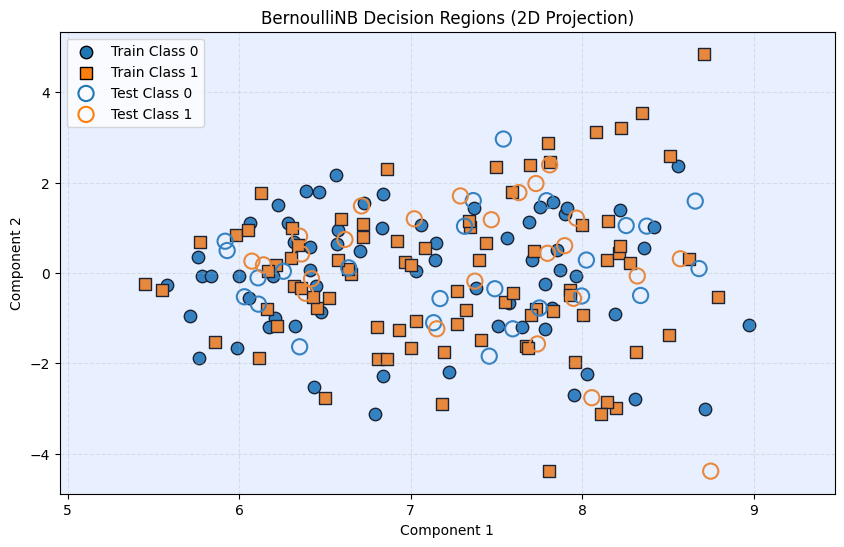

In [32]:
plt.figure(figsize=(10,6))
plt.scatter(X_train_2d[y_train==0,0], X_train_2d[y_train==0,1], marker='o', s=80, label='Train Class 0', edgecolor='k')
plt.scatter(X_train_2d[y_train==1,0], X_train_2d[y_train==1,1], marker='s', s=80, label='Train Class 1', edgecolor='k')
plt.scatter(X_test_2d[y_test==0,0], X_test_2d[y_test==0,1], facecolors='none', edgecolors='C0', s=120, linewidths=1.5, label='Test Class 0')
plt.scatter(X_test_2d[y_test==1,0], X_test_2d[y_test==1,1], facecolors='none', edgecolors='C1', s=120, linewidths=1.5, label='Test Class 1')
xx, yy = np.meshgrid(
    np.linspace(X_all_2d[:,0].min()-0.5, X_all_2d[:,0].max()+0.5, 300),
    np.linspace(X_all_2d[:,1].min()-0.5, X_all_2d[:,1].max()+0.5, 300)
)
grid = np.c_[xx.ravel(), yy.ravel()]
grid_bin = np.column_stack([
    (grid[:,0] > thr0).astype(int),
    (grid[:,1] > thr1).astype(int)
])
Z = bnb_2d.predict(grid_bin).reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.2, cmap=plt.cm.coolwarm)
plt.title("BernoulliNB Decision Regions (2D Projection)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()
plt.grid(alpha=0.3, linestyle='--')
plt.show()